In [ ]:
# This file is to evaluate EP Based D-CNOT(Entanglement Purification Based Distributed CNOT). 
# We can apply noise to the entanglements that will cause degradation(decoherence) and then check the result of D-CNOT.

In [1]:
# This code cell is to define the circuit of EP Based D-CNOT. You can visualize the circuit by "circuit.draw("mpl")".
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
    phase_amplitude_damping_error,
)
import numpy as np
import random
qreg_q = QuantumRegister(6, 'q')
creg_c0 = ClassicalRegister(1, 'c0')
creg_c1 = ClassicalRegister(1, 'c1')
creg_c2 = ClassicalRegister(1, 'c2')
creg_c3 = ClassicalRegister(1, 'c3')
circuit = QuantumCircuit(qreg_q, creg_c0, creg_c1, creg_c2, creg_c3)

circuit.h(qreg_q[0])
circuit.h(qreg_q[1])
circuit.h(qreg_q[3])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[4])
circuit.cx(qreg_q[1], qreg_q[3])
circuit.cx(qreg_q[2], qreg_q[4])
circuit.measure(qreg_q[3], creg_c0[0])
circuit.measure(qreg_q[4], creg_c1[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.measure(qreg_q[1], creg_c2[0])
circuit.x(qreg_q[2]).c_if(creg_c2, 1)
circuit.cx(qreg_q[2], qreg_q[5])
circuit.h(qreg_q[2])
circuit.measure(qreg_q[2], creg_c3[0])
circuit.z(qreg_q[0]).c_if(creg_c3, 1)
circuit.measure_all()
#circuit.draw("mpl")

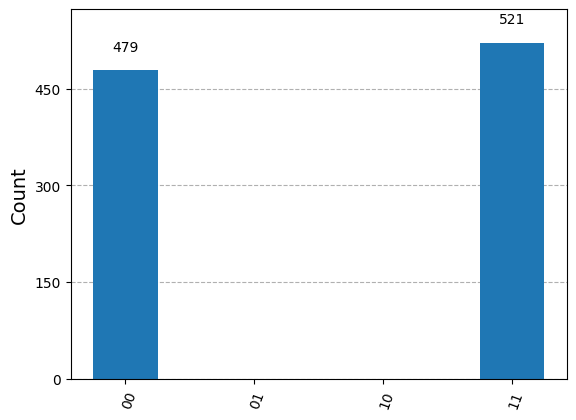

In [2]:
# This code cell is to perform the ideal simulation (without noise).
# Repeatedly exec circuit for 1000 times.
# The result shows the probability of case:00 + case:11 is 100% which means that the control_qubit is totally related to target_qubit. (D-CNOT's success rate is 100%)
# If case:00 + case:11 is not 100% which means control_qubit is not totally related to target_qubit. (D-CNOT's success rate is not 100%.)
# Especially, if case:00 +case:11 is only 50% which means control_qubit is not realated to target_qubit. (D-CNOT's success rate is 0%.)

sim_ideal = AerSimulator()
counts = sim_ideal.run(circuit,shots=1000).result().get_counts()
target_qubits_counts = {'00': 0, '01':0, '10':0, '11': 0}
for outcome, count in counts.items():
    target_qubits = outcome[5]+outcome[0]  # choose control_qubit(Alice side) q0(outcome[5]) and target_qubit(Bob side) q5(outcome[0])
    target_qubits_counts[target_qubits] += count
plot_histogram(target_qubits_counts)

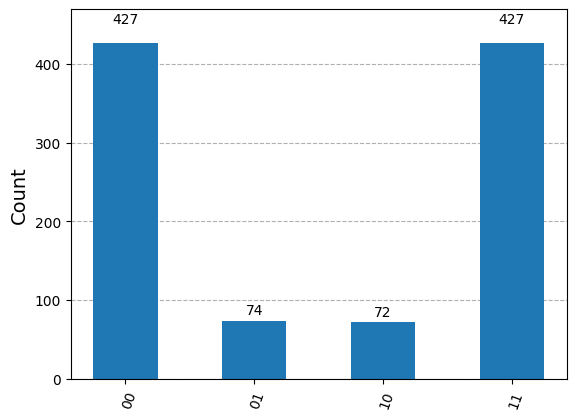

In [40]:
# This code cell is to simulate realistic cases (with noise)(all entanglements suffered the same level of noise)
# You can adjust p_depo_xx (e.g., p_depo_q1q2=0.2, p_depo_q3q4=0.2) to evaluate the performance of EP Based D-CNOT.
p_depo_q1q2 = 0.3  # depolarizing error probability,0~1
p_depo_q3q4 = 0.3  # depolarizing error probability,0~1

# QuantumError objects
depol_noise_q1q2 = depolarizing_error(p_depo_q1q2, 2)
depol_noise_q3q4 = depolarizing_error(p_depo_q3q4, 2)

# Create noisy simulator backend
noise_set = NoiseModel()
noise_set.add_quantum_error(depol_noise_q1q2, ['cx'], [1,2])
noise_set.add_quantum_error(depol_noise_q3q4, ['cx'], [3,4])

sim_noise = AerSimulator(noise_model=noise_set)

# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
circuit_tnoise = passmanager.run(circuit)

# Run and get counts
counts = sim_noise.run(circuit_tnoise,shots=1000).result().get_counts()

target_qubits_counts = {'00': 0, '01':0, '10':0, '11': 0}
for outcome, count in counts.items():
    target_qubits = outcome[5]+outcome[0]  # choose control_qubit(Alice side) q0(outcome[5]) and target_qubit(Bob side) q5(outcome[0])
    target_qubits_counts[target_qubits] += count
plot_histogram(target_qubits_counts)

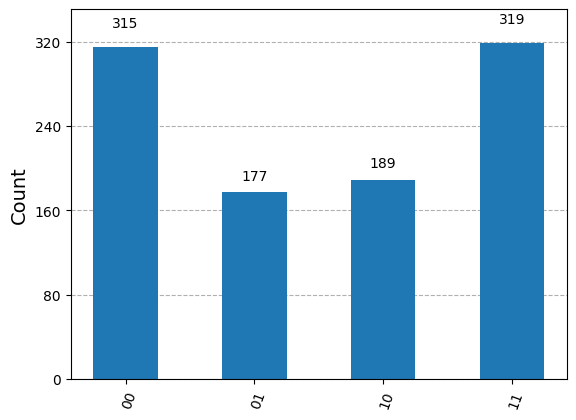

In [48]:
# This code cell is to simulate realistic cases (with noise)(one entanglement is totally decoherent, another two entanglements are also suffered noise)
# In these cases, we have 2/3 probability in selecting the totally decoherent entanglement. (The reason is that we should select two entanglements for EP)
# You can adjust depo_rate to control the noise on the another two entanglements.

target_qubits_counts = {'00': 0, '01':0, '10':0, '11': 0}
depo_rate=0.2 # depolarizing error probability,0~1

for i in range(1000):
    weights = [1/3, 2/3]
    
    choices = [depo_rate, 1]
    result_depo = random.choices(choices, weights=weights, k=1)[0]

    p_depo_q1q2 = result_depo  # depolarizing error probability
    p_depo_q3q4 = depo_rate  # depolarizing error probability

    # QuantumError objects
    depol_noise_q1q2 = depolarizing_error(p_depo_q1q2, 2)
    depol_noise_q3q4 = depolarizing_error(p_depo_q3q4, 2)

    # Create noisy simulator backend
    noise_set = NoiseModel()
    noise_set.add_quantum_error(depol_noise_q1q2, ['cx'], [1,2])
    noise_set.add_quantum_error(depol_noise_q3q4, ['cx'], [3,4])
    
    sim_noise = AerSimulator(noise_model=noise_set)
    
    # Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
    circuit_tnoise = passmanager.run(circuit)
    
    # Run and get counts
    counts = sim_noise.run(circuit_tnoise,shots=1).result().get_counts()
    for outcome, count in counts.items():
        target_qubits = outcome[5]+outcome[0]  # choose control_qubit(Alice side) q0(outcome[5]) and target_qubit(Bob side) q5(outcome[0])
        target_qubits_counts[target_qubits] += count
        
plot_histogram(target_qubits_counts)